# Preprocesamiento I

## 1. Verificar que no se repiten los nombres de los archivos de imagenes

In [1]:
import os
import json
from collections import defaultdict

In [2]:


def encontrar_imagenes_duplicadas_por_nombre(working_directory):
    imagenes = defaultdict(list)

    for marca in os.listdir(working_directory):
        marca_path = os.path.join(working_directory, marca)
        if not os.path.isdir(marca_path):
            continue

        for modelo in os.listdir(marca_path):
            modelo_path = os.path.join(marca_path, modelo)
            annotation_path = os.path.join(modelo_path, 'instances_default.json')

            if not os.path.isfile(annotation_path):
                continue

            with open(annotation_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                for img in data.get('images', []):
                    nombre_imagen = img.get('file_name')
                    if nombre_imagen:
                        ruta_logica = os.path.join(marca, modelo)
                        imagenes[nombre_imagen].append(ruta_logica)

    # Buscar duplicados
    duplicados = {k: v for k, v in imagenes.items() if len(v) > 1}

    if duplicados:
        print("Imágenes duplicadas encontradas en múltiples subcarpetas:\n")
        for nombre, rutas in duplicados.items():
            print(f"{nombre}:")
            for r in rutas:
                print(f"  - {r}")
            print()
    else:
        print("No se encontraron imágenes duplicadas por nombre.")




In [4]:
encontrar_imagenes_duplicadas_por_nombre("bing-model-images")

No se encontraron imágenes duplicadas por nombre.


## 2. Formato COCO JSON

### 2.1 Juntar los COCO JSON de los modelos en uno solo

In [5]:
import os
import json
import pandas as pd

In [11]:
def merge_annotations_with_hierarchy(working_dir, xlsx_path, output_json_path):
    # Read model-type mapping from Excel
    df = pd.read_excel(xlsx_path)
    model_info = {
        (row['make'], row['model']): row['type']
        for _, row in df.iterrows()
    }

    image_id_counter = 0
    annotation_id_counter = 0
    category_id_counter = 0

    all_images = []
    all_annotations = []
    all_categories = []
    category_lookup = {}

    for brand in os.listdir(working_dir):
        brand_path = os.path.join(working_dir, brand)
        if not os.path.isdir(brand_path):
            continue

        for model in os.listdir(brand_path):
            model_path = os.path.join(brand_path, model)
            json_path = os.path.join(model_path, 'instances_default.json')

            if not os.path.isfile(json_path):
                continue

            vehicle_type = model_info.get((brand, model), "Unknown")

            category_key = (model, brand, vehicle_type)
            if category_key not in category_lookup:
                category_lookup[category_key] = category_id_counter
                all_categories.append({
                    "id": category_id_counter,
                    "name": model,
                    "supercategory": brand,
                    "make": brand,
                    "type": vehicle_type
                })
                category_id_counter += 1

            current_category_id = category_lookup[category_key]

            with open(json_path, 'r', encoding='utf-8') as f:
                coco_data = json.load(f)

            image_id_map = {}
            for image in coco_data.get("images", []):
                new_image = image.copy()
                new_image["id"] = image_id_counter
                image_id_map[image["id"]] = image_id_counter
                all_images.append(new_image)
                image_id_counter += 1

            for ann in coco_data.get("annotations", []):
                new_ann = ann.copy()
                new_ann["id"] = annotation_id_counter
                new_ann["image_id"] = image_id_map[ann["image_id"]]
                new_ann["category_id"] = current_category_id
                all_annotations.append(new_ann)
                annotation_id_counter += 1

    merged_coco = {
        "images": all_images,
        "annotations": all_annotations,
        "categories": all_categories
    }
    
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_json_path), exist_ok=True)

    with open(output_json_path, "w", encoding="utf-8") as f_out:
        json.dump(merged_coco, f_out, ensure_ascii=False, indent=2)



In [12]:
merge_annotations_with_hierarchy("bing-model-images", "top-50-type.xlsx", "merged-dataset/merged_annotations.json")

### 2.2. Copiar imagenes a nuevo directorio

In [13]:
import os
import json
import shutil

In [14]:
def copy_images_from_subfolders(working_dir, output_images_path):
    os.makedirs(output_images_path, exist_ok=True)

    for brand in os.listdir(working_dir):
        brand_path = os.path.join(working_dir, brand)
        if not os.path.isdir(brand_path):
            continue

        for model in os.listdir(brand_path):
            model_path = os.path.join(brand_path, model)
            json_path = os.path.join(model_path, 'instances_default.json')

            if not os.path.isfile(json_path):
                continue

            with open(json_path, 'r', encoding='utf-8') as f:
                coco_data = json.load(f)

            for image in coco_data.get("images", []):
                image_filename = image.get("file_name")
                if not image_filename:
                    continue

                src_image_path = os.path.join(model_path, image_filename)
                dst_image_path = os.path.join(output_images_path, image_filename)

                if os.path.exists(src_image_path):
                    shutil.copy2(src_image_path, dst_image_path)
                else:
                    print(f"[WARNING] Image not found: {src_image_path}")


In [15]:
copy_images_from_subfolders("bing-model-images", "merged-dataset/images")


### 2.3. Verificar Bounding Boxes

In [19]:
import os
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
import random

In [20]:
def save_coco_bboxes_to_images(image_dir, annotation_path, output_dir='output', max_images=None):
    """
    Save images with bounding boxes drawn from COCO annotations.

    Parameters:
        image_dir (str): Directory containing the images.
        annotation_path (str): Full path to the COCO annotation file.
        output_dir (str): Directory to save output images with drawn bounding boxes.
        max_images (int, optional): If provided, randomly selects up to this number of images (without repetition).
    """
    os.makedirs(output_dir, exist_ok=True)
    coco = COCO(annotation_path)
    image_ids = coco.getImgIds()

    if max_images is not None and max_images < len(image_ids):
        image_ids = random.sample(image_ids, max_images)

    for img_id in image_ids:
        img_data = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_data['file_name'])
        output_path = os.path.join(output_dir, img_data['file_name'])

        if not os.path.exists(img_path):
            print(f"[WARNING] Image file not found: {img_path}")
            continue

        image = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            x, y, w, h = ann['bbox']
            draw.rectangle([x, y, x + w, y + h], outline='red', width=3)

        image.save(output_path)


In [21]:
save_coco_bboxes_to_images(
    image_dir='merged-dataset/images',
    annotation_path='merged-dataset/merged_annotations.json',
    output_dir='merged-dataset/images_bbox_test',
    max_images=10
)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### 2.4 Visualizacion de Bounding Boxes

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pycocotools.coco import COCO

In [4]:


def visualize_coco_bboxes(image_dir, annotation_file, num_images=4):
    """
    Display COCO bounding boxes for a few sample images.

    Parameters:
        image_dir (str): Path to the directory containing the images and annotation file.
        annotation_filename (str): COCO JSON annotation filename. Default is '_annotations.coco.json'.
        num_images (int): Number of images to display. Default is 4.
    """
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()[:num_images]

    rows = cols = int(num_images**0.5)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
    axs = axs.flatten()

    for i, img_id in enumerate(image_ids):
        img_data = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_data['file_name'])
        image = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            x, y, w, h = ann['bbox']
            draw.rectangle([x, y, x + w, y + h], outline='red', width=10)

        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(img_data['file_name'])

    # Hide any unused subplots
    for j in range(len(image_ids), len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


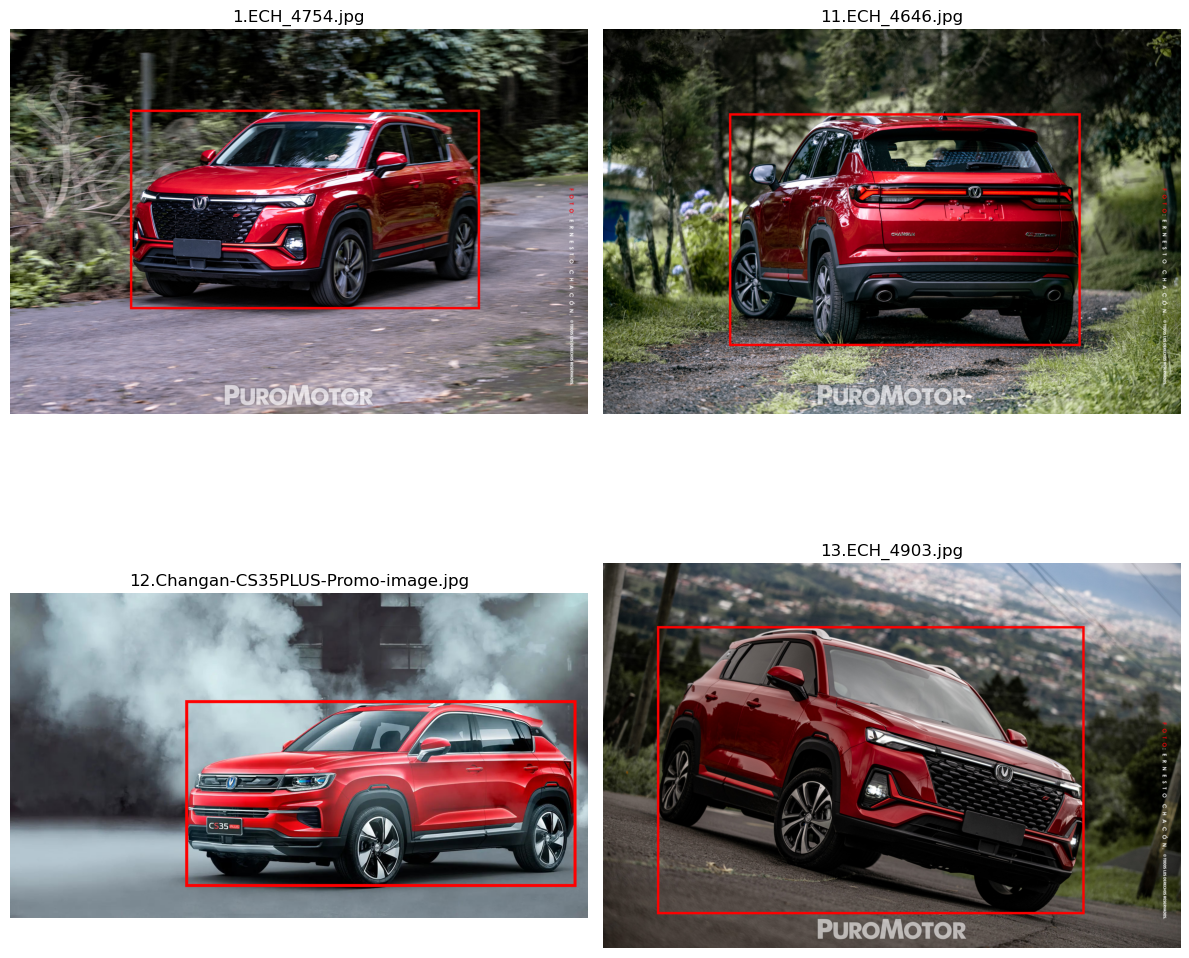

In [5]:
visualize_coco_bboxes("merged-dataset/images","merged-dataset/merged_annotations.json")

## 3. Crear subsets

### 3.1 Division del dataset

In [22]:
import os
import json
import random
from collections import defaultdict
from typing import Tuple

In [23]:
def split_dataset(
    images_path: str,
    coco_json_path: str,
    output_path: str,
    stratified: bool = True,
    split_ratio: Tuple[float, float, float] = (0.8, 0.1, 0.1)
):
    os.makedirs(output_path, exist_ok=True)

    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)

    images = coco['images']
    annotations = coco['annotations']
    categories = coco['categories']

    image_id_to_image = {img['id']: img for img in images}
    image_id_to_annots = defaultdict(list)
    for ann in annotations:
        image_id_to_annots[ann['image_id']].append(ann)

    if stratified:
        image_id_to_categories = defaultdict(set)
        for ann in annotations:
            image_id_to_categories[ann['image_id']].add(ann['category_id'])

        category_to_image_ids = defaultdict(set)
        for img_id, cat_ids in image_id_to_categories.items():
            for cat_id in cat_ids:
                category_to_image_ids[cat_id].add(img_id)

        train_ids, valid_ids, test_ids = set(), set(), set()
        for cat_id, img_ids in category_to_image_ids.items():
            img_ids = list(img_ids)
            random.shuffle(img_ids)
            n = len(img_ids)
            n_train = int(n * split_ratio[0])
            n_valid = int(n * split_ratio[1])
            train_ids.update(img_ids[:n_train])
            valid_ids.update(img_ids[n_train:n_train + n_valid])
            test_ids.update(img_ids[n_train + n_valid:])
    else:
        all_image_ids = list(image_id_to_image.keys())
        random.shuffle(all_image_ids)
        n = len(all_image_ids)
        n_train = int(n * split_ratio[0])
        n_valid = int(n * split_ratio[1])
        train_ids = set(all_image_ids[:n_train])
        valid_ids = set(all_image_ids[n_train:n_train + n_valid])
        test_ids = set(all_image_ids[n_train + n_valid:])

    def save_subset(image_ids_set, filename):
        subset_images = [image_id_to_image[i] for i in image_ids_set]
        subset_annotations = [ann for ann in annotations if ann['image_id'] in image_ids_set]
        output_json = {
            'images': subset_images,
            'annotations': subset_annotations,
            'categories': categories
        }
        with open(os.path.join(output_path, filename), 'w', encoding='utf-8') as f:
            json.dump(output_json, f, indent=2)

    save_subset(train_ids, 'train.json')
    save_subset(valid_ids, 'valid.json')
    save_subset(test_ids, 'test.json')

    print(f"COCO JSONs saved to: {output_path} | Stratified: {stratified}")


In [24]:
split_dataset(
    images_path='merged-dataset/images',
    coco_json_path='merged-dataset/merged_annotations.json',
    output_path='merged-dataset/subsets',
    stratified=True
)

COCO JSONs saved to: merged-dataset/subsets | Stratified: True


### 3.2. Verificacion de la separacion con estratificacion

In [3]:
import os
import json
from collections import defaultdict

In [4]:

def count_images_per_category_in_jsons(input_path):
    """
    Reads all COCO-format JSON files in a directory and prints how many unique images are associated with each category.

    Parameters:
        input_path (str): Path to the directory containing COCO JSON files.
    """
    for file_name in os.listdir(input_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(input_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                coco = json.load(f)
                
            total_images = len(coco.get('images', []))
            category_id_to_name = {cat['id']: cat['name'] for cat in coco['categories']}
            images_per_category = defaultdict(set)

            for annotation in coco['annotations']:
                category_id = annotation['category_id']
                image_id = annotation['image_id']
                images_per_category[category_id].add(image_id)

            print(f"\nFile: {file_name}")
            print(f"Total images: {total_images}")
            for category_id, image_ids in images_per_category.items():
                category_name = category_id_to_name.get(category_id, 'Unknown')
                print(f"- {category_name}: {len(image_ids)} images")


In [5]:
count_images_per_category_in_jsons('merged-dataset/subsets')


File: test.json
Total images: 185
- Changan CS35: 4 images
- Changan CS55: 3 images
- Changan New Van: 4 images
- Chevrolet Camaro: 3 images
- Chevrolet Cruze: 4 images
- Chevrolet Onix: 4 images
- Chevrolet Spark: 3 images
- Chevrolet Tracker: 4 images
- Glory 330: 3 images
- Glory 500: 3 images
- Glory 580: 4 images
- Hyundai Accent: 4 images
- Hyundai Creta: 3 images
- Hyundai Elantra: 4 images
- Hyundai i20: 4 images
- Hyundai Santa Fe: 4 images
- Hyundai Sonata: 4 images
- Hyundai Tucson: 4 images
- Hyundai Veloster: 4 images
- JAC JS4: 4 images
- JAC T8: 3 images
- Kia Niro: 4 images
- Kia Rio: 3 images
- Kia Seltos: 4 images
- Kia Sorento: 4 images
- Kia Soul: 3 images
- Kia Sportage: 4 images
- Nissan Kicks: 4 images
- Nissan Sentra: 4 images
- Nissan Versa: 3 images
- Suzuki Jimny: 4 images
- Suzuki Swift: 4 images
- Suzuki Vitara: 4 images
- Toyota 4Runner: 3 images
- Toyota C-HR: 4 images
- Toyota Camry: 4 images
- Toyota Celica: 4 images
- Toyota Corolla: 4 images
- Toyota

### 3.3. Creacion de carpetas de los subsets

In [28]:
import os
import json
import shutil

In [29]:

def copy_coco_images_to_output(coco_json_path, input_images_path, output_images_path):
    """
    Copies only the images referenced in a COCO JSON file from the input path to the output path.

    Parameters:
        coco_json_path (str): Path to the COCO JSON file.
        input_images_path (str): Path to the folder containing the source images.
        output_images_path (str): Path where the selected images will be copied.
    """
    os.makedirs(output_images_path, exist_ok=True)

    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)

    image_files = {img['file_name'] for img in coco['images']}

    for img_file in image_files:
        src_path = os.path.join(input_images_path, img_file)
        dst_path = os.path.join(output_images_path, img_file)

        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"Warning: Image not found -> {src_path}")


In [30]:
copy_coco_images_to_output(
    coco_json_path='merged-dataset/subsets/test.json',
    input_images_path='merged-dataset/images',
    output_images_path='merged-dataset/test-images'
)


## 4. Revision de las dimensiones y extensiones de la imagen

### 4.1 Revision de dimensiones

In [6]:
import json
from collections import Counter

In [7]:
def display_image_dimensions_with_stats(coco_json_path):
    """
    Loads a COCO JSON and displays total image count,
    frequency and proportional frequency of each (width, height) dimension.

    Parameters:
        coco_json_path (str): Path to the COCO-format JSON file.
    """
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)

    dimensions = [(img['width'], img['height']) for img in coco_data.get('images', [])]
    total_images = len(dimensions)
    dimension_counts = Counter(dimensions)

    print(f"Total number of images: {total_images}\n")
    print("Image dimensions with frequency and proportional frequency:")
    for dim, count in sorted(dimension_counts.items()):
        proportion = (count / total_images) * 100
        print(f"{dim}: {count} images ({proportion:.2f}%)")


In [8]:
display_image_dimensions_with_stats('merged-dataset/merged_annotations.json')

Total number of images: 1471

Image dimensions with frequency and proportional frequency:
(300, 187): 1 images (0.07%)
(300, 300): 1 images (0.07%)
(320, 158): 1 images (0.07%)
(380, 600): 1 images (0.07%)
(400, 200): 1 images (0.07%)
(480, 190): 1 images (0.07%)
(480, 288): 1 images (0.07%)
(480, 311): 1 images (0.07%)
(480, 320): 2 images (0.14%)
(480, 360): 1 images (0.07%)
(500, 265): 1 images (0.07%)
(500, 350): 1 images (0.07%)
(512, 320): 1 images (0.07%)
(558, 279): 1 images (0.07%)
(565, 422): 1 images (0.07%)
(580, 780): 3 images (0.20%)
(600, 338): 1 images (0.07%)
(600, 400): 2 images (0.14%)
(624, 569): 1 images (0.07%)
(628, 394): 1 images (0.07%)
(630, 354): 1 images (0.07%)
(640, 480): 6 images (0.41%)
(640, 520): 1 images (0.07%)
(650, 430): 1 images (0.07%)
(650, 443): 1 images (0.07%)
(652, 398): 1 images (0.07%)
(653, 327): 1 images (0.07%)
(660, 360): 1 images (0.07%)
(672, 420): 2 images (0.14%)
(690, 518): 1 images (0.07%)
(700, 456): 1 images (0.07%)
(700, 467):

### 4.2 Revision de extensiones

#### i. get_unique_image_extensions

In [ ]:
import os
import json

def get_unique_image_extensions(coco_json_path):
    """
    Reads a COCO-format JSON file and prints the unique image file extensions.

    Parameters:
        coco_json_path (str): Path to the COCO JSON annotation file.
    """
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)

    extensions = set()
    for image in coco_data.get("images", []):
        file_name = image.get("file_name", "")
        _, ext = os.path.splitext(file_name)
        if ext:
            extensions.add(ext.lower())

    print("Unique image file extensions found in the dataset:")
    for ext in sorted(extensions):
        print(ext)


In [ ]:
get_unique_image_extensions('merged-dataset\merged_annotations.json')

#### ii. show_non_jpg_png_images_with_categories

In [ ]:
import os
import json
from collections import defaultdict

def show_non_jpg_png_images_with_categories(coco_json_path):
    """
    Reads a COCO-format JSON file and prints how many images are not in JPG or PNG format,
    along with their file names and associated categories.

    Parameters:
        coco_json_path (str): Path to the COCO JSON annotation file.
    """
    allowed_extensions = {'.jpg', '.jpeg', '.png'}
    non_compliant_info = {}

    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)

    # Map image_id to file_name
    image_id_to_filename = {
        img['id']: img['file_name'] for img in coco.get('images', [])
    }

    # Map category_id to category name
    category_id_to_name = {
        cat['id']: cat['name'] for cat in coco.get('categories', [])
    }

    # Map image_id to list of category_ids
    image_id_to_categories = defaultdict(set)
    for ann in coco.get('annotations', []):
        image_id_to_categories[ann['image_id']].add(ann['category_id'])

    # Identify non-compliant images and collect category names
    for image_id, file_name in image_id_to_filename.items():
        _, ext = os.path.splitext(file_name)
        if ext.lower() not in allowed_extensions:
            category_names = [category_id_to_name[cid] for cid in image_id_to_categories[image_id]]
            non_compliant_info[file_name] = category_names

    # Output results
    print(f"Total non-JPG/PNG images: {len(non_compliant_info)}")
    for file_name, categories in non_compliant_info.items():
        print(f"- {file_name}: Categories: {categories}")


In [ ]:
show_non_jpg_png_images_with_categories('merged-dataset\merged_annotations.json')

#### iii. convert_to_jpg_overwrite(input_path)

In [1]:
import os
from PIL import Image

def convert_to_jpg_overwrite(input_path):
    """
    Recursively converts .gif and .webp images to .jpg in a given directory and overwrites them.

    Parameters:
        input_path (str): Root directory containing folders with images.
    """
    supported_extensions = {'.gif', '.webp'}

    for root, _, files in os.walk(input_path):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext in supported_extensions:
                original_path = os.path.join(root, file)
                new_path = os.path.splitext(original_path)[0] + '.jpg'

                try:
                    with Image.open(original_path) as img:
                        rgb_img = img.convert('RGB')  # Ensure compatible format
                        rgb_img.save(new_path, 'JPEG')
                    os.remove(original_path)
                    print(f"Converted and replaced: {original_path} -> {new_path}")
                except Exception as e:
                    print(f"Failed to convert {original_path}: {e}")


In [2]:
convert_to_jpg_overwrite("merged-dataset/images")

Converted and replaced: merged-dataset/images\1.2025_Toyota_4Runner_Trailhunter_Everest_005-2048x1366-1.webp -> merged-dataset/images\1.2025_Toyota_4Runner_Trailhunter_Everest_005-2048x1366-1.jpg
Converted and replaced: merged-dataset/images\10.changan-cs55-plus-exterior_3.webp -> merged-dataset/images\10.changan-cs55-plus-exterior_3.jpg
Converted and replaced: merged-dataset/images\10.toyota-land-rover-cruiser-first-editon-reunion-alemania-2-1280x1018.webp -> merged-dataset/images\10.toyota-land-rover-cruiser-first-editon-reunion-alemania-2-1280x1018.jpg
Converted and replaced: merged-dataset/images\12.Changan-CS35PLUS-Promo-image.webp -> merged-dataset/images\12.Changan-CS35PLUS-Promo-image.jpg
Converted and replaced: merged-dataset/images\12.Chevrolet-Spark_74-scaled.webp -> merged-dataset/images\12.Chevrolet-Spark_74-scaled.jpg
Converted and replaced: merged-dataset/images\12.DSC_8221-scaled.jpg.webp -> merged-dataset/images\12.DSC_8221-scaled.jpg.jpg
Converted and replaced: merged

In [ ]:
convert_to_jpg_overwrite("merged-dataset/train")

In [ ]:
convert_to_jpg_overwrite("merged-dataset/valid")

### 4.3 Redimensionamiento proporcional

In [9]:
import os
import json
import cv2
from tqdm import tqdm

In [ ]:
def resize_images_and_coco_annotations(
    short_side_target,
    max_long_side,
    coco_json_path,
    images_dir,
    output_images_dir,
    output_json_path
):
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(os.path.dirname(output_json_path), exist_ok=True)

    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)

    updated_images = []
    updated_annotations = []

    # Create a lookup for annotations by image_id
    annotations_lookup = {}
    for ann in coco_data['annotations']:
        annotations_lookup.setdefault(ann['image_id'], []).append(ann)

    for image_info in tqdm(coco_data['images'], desc="Processing images"):
        file_name = image_info['file_name']
        image_path = os.path.join(images_dir, file_name)
        output_image_path = os.path.join(output_images_dir, file_name)

        image = cv2.imread(image_path)
        if image is None:
            print(f"[WARNING] Could not load image: {file_name}")
            continue

        h, w = image.shape[:2]

        # Determine scale factor
        short_side = min(w, h)
        long_side = max(w, h)

        scale = short_side_target / short_side
        if long_side * scale > max_long_side:
            scale = max_long_side / long_side

        new_w = int(w * scale)
        new_h = int(h * scale)

        # Resize and save image
        resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(output_image_path, resized_image)

        # Update image info
        new_image_info = image_info.copy()
        new_image_info['width'] = new_w
        new_image_info['height'] = new_h
        updated_images.append(new_image_info)

        # Update corresponding annotations
        if image_info['id'] in annotations_lookup:
            for ann in annotations_lookup[image_info['id']]:
                x, y, w_box, h_box = ann['bbox']
                x *= scale
                y *= scale
                w_box *= scale
                h_box *= scale

                new_ann = ann.copy()
                new_ann['bbox'] = [x, y, w_box, h_box]
                new_ann['area'] = w_box * h_box
                updated_annotations.append(new_ann)

    # Assemble updated COCO data
    new_coco = coco_data.copy()
    new_coco['images'] = updated_images
    new_coco['annotations'] = updated_annotations

    with open(output_json_path, 'w', encoding='utf-8') as f_out:
        json.dump(new_coco, f_out, indent=2)
